First, we create a custom Dataset class to handle our .npy files. Then, we randomly split the data into two dataloaders, the training one (90% of the whole dataset) and the testing one (10%). Since this assignment is introductory, we didn't create a validation set to tweak our hyperparameters.

In [70]:
import torch
from torchvision import datasets
import numpy as np
import glob

class npyDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    self.path = glob.glob(path)
    self.img, self.labels = self.get_data(self.path)

  def __len__(self):
    return len(self.path)
  
  def __getitem__(self, idx):
    return self.img[idx], self.labels[idx]
    
  def get_data(self, files):
    img = []
    labels = []
    for f in files:
      data = np.load(f, allow_pickle=True)
      img.append(torch.from_numpy(data[0]))
      labels.append(torch.tensor(data[1]))
    return img, labels

full_dataset = npyDataset('/content/drive/MyDrive/data/*.npy')

train_size = int(len(full_dataset)*0.9)
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset=full_dataset, lengths=[train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32) # set workers if too slow
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32)

Plot a few images.

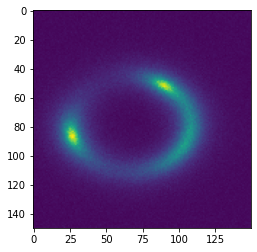

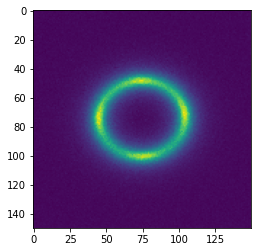

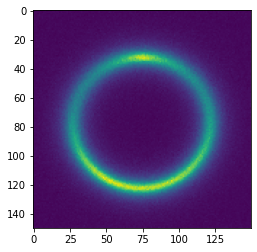

In [129]:
import matplotlib.pyplot as plt

for data in train_loader:
  plt.imshow(data[0].reshape(-1, 150, 150)[0])
  plt.show()
  plt.imshow(data[0].reshape(-1, 150, 150)[13])
  plt.show()
  plt.imshow(data[0].reshape(-1, 150, 150)[25])
  plt.show()
  break

Next, we define our network. We used a 5-layer CNN with a convolution operation, a batch normalization, a relu non-linearity and a max-pool in each layer, apart from the last one which performs a simple affine transformation followed by a relu.

In [137]:
import torch.nn as nn

class BasicCNN(nn.Module):
    def __init__(self, input_dim, output_dim, channels=[2, 4, 2, 1], kernels=[3, 3, 3, 1]):
        super(BasicCNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.channels = channels
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=self.input_dim, out_channels=channels[0], kernel_size=kernels[0]),
                                    nn.BatchNorm2d(channels[0]),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=kernels[0]))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=kernels[1]),
                                    nn.BatchNorm2d(channels[1]),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=kernels[1]))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=kernels[2]),
                                    nn.BatchNorm2d(channels[2]),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=kernels[2]))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=channels[2], out_channels=channels[3], kernel_size=kernels[3]),
                                    nn.BatchNorm2d(channels[3]),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=kernels[3]))
        self.linear = nn.Sequential(nn.Linear(16, self.output_dim),
                                    nn.ReLU(inplace=True))
    
    def forward(self, x):
      x = x.view(-1, 1, 150, 150)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = x.view(x.shape[0], -1)
      x = self.linear(x)
      return x
  
    def train(self, loss_function, optimizer, data_loader, epochs):
      for epoch in range(epochs):
        for data in data_loader:
          images, labels = data[0].to(device, dtype=torch.float), data[1].to(device, dtype=torch.float)
          prediction = self(images).view(-1)
          loss = loss_function(prediction, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        print("Epoch:", epoch+1, "and train mse:", self.test(data_loader))
        
    def test(self, data_loader):
      count, total = 0, 0
      for data in data_loader:
        with torch.no_grad():
          images, labels = data[0].to(device, dtype=torch.float), data[1].to(device, dtype=torch.float)
          scores = self(images).view(-1)
          total += nn.functional.mse_loss(scores, labels, reduction='sum')
          count += len(data) # account for len(dataset) non divisible by batch_size
      return total / count

Train the model.

In [149]:
import time, random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic=True

model = BasicCNN(input_dim=1, output_dim=1)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

start = time.perf_counter()

model.train(loss_function=loss_function, optimizer=optimizer, data_loader=train_loader, epochs=100)

end = time.perf_counter()

print(f"Trained the model in {end - start:0.5f} seconds")

Epoch: 1 and train mse: tensor(6403.3999, device='cuda:0')
Epoch: 2 and train mse: tensor(3598.0457, device='cuda:0')
Epoch: 3 and train mse: tensor(3300.5295, device='cuda:0')
Epoch: 4 and train mse: tensor(3158.5703, device='cuda:0')
Epoch: 5 and train mse: tensor(3033.3687, device='cuda:0')
Epoch: 6 and train mse: tensor(2944.7903, device='cuda:0')
Epoch: 7 and train mse: tensor(2847.1726, device='cuda:0')
Epoch: 8 and train mse: tensor(2756.8083, device='cuda:0')
Epoch: 9 and train mse: tensor(2689.3213, device='cuda:0')
Epoch: 10 and train mse: tensor(2640.3743, device='cuda:0')
Epoch: 11 and train mse: tensor(2590.3418, device='cuda:0')
Epoch: 12 and train mse: tensor(2555.4224, device='cuda:0')
Epoch: 13 and train mse: tensor(2527.4407, device='cuda:0')
Epoch: 14 and train mse: tensor(2500.2170, device='cuda:0')
Epoch: 15 and train mse: tensor(2477.1104, device='cuda:0')
Epoch: 16 and train mse: tensor(2484.9536, device='cuda:0')
Epoch: 17 and train mse: tensor(2514.6450, device

Evaluate model's performance in the training set.

In [150]:
test_acc = model.test(data_loader=test_loader)
print("Test mse:", test_acc)

Test mse: tensor(1928.4100, device='cuda:0')


We conclude that the model's performance is satisfactory, although the mse alone is quite uninformative as a metric.

In [135]:
for data in test_loader:
  images, labels = data[0].to(device, dtype=torch.float), data[1].to(device, dtype=torch.float)
  scores = model(images).view(-1)
  print(scores, labels)
  print(nn.functional.mse_loss(scores[:2], labels[:2], reduction='sum'))
  break

tensor([201.7247, 182.6731, 196.5825, 348.3768, 338.9647, 132.7507, 279.6628,
        133.8546, 377.8951, 315.7931, 234.2127, 300.3079, 213.2839,  89.8723,
        140.7586, 262.3759, 342.5344, 362.8394,  96.4672,  87.1819, 372.3148,
        292.8281, 326.7325, 117.9891, 262.0303, 328.3035, 280.2587,  83.7239,
        309.2741, 183.5129, 266.3009, 321.9518], device='cuda:0',
       grad_fn=<ViewBackward>) tensor([196.9989, 197.8809, 186.3139, 356.6482, 339.6410, 152.8824, 286.4112,
        153.5895, 389.8203, 319.9333, 239.9572, 287.5869, 230.6805, 117.5029,
        148.0307, 263.9063, 346.7954, 390.2194, 118.3035, 111.9580, 371.7372,
        293.9063, 369.3291, 132.3423, 273.3764, 323.0374, 288.3217, 110.2821,
        305.1413, 197.1893, 276.3833, 328.7582], device='cuda:0')
tensor(253.6116, device='cuda:0', grad_fn=<MseLossBackward>)
